binning process

In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from optbinning import BinningProcess

(CVXPY) Aug 05 11:49:53 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 05 11:49:53 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
df = pd.read_parquet('credit_data.parquet')

In [3]:
df = df.rename(columns = {
    'Sex': 'Gender',
    'Saving accounts': 'Saving_acc',
    'Checking account': 'Checking_acc',
    'Credit amount': 'Credit_mnt',
})

df.Gender = df.Gender.apply(lambda x: 1 if x == 'male' else 0)
df.Risk = df.Risk.apply(lambda x: 1 if x == 'good' else 0)

df.Saving_acc = df.Saving_acc.map({
    None: 'none',
    'little': 'low',
    'moderate': 'medium',
    'quite rich': 'high',
    'rich': 'high'
})
df.Checking_acc = df.Checking_acc.map({
    None: 'none',
    'little': 'low',
    'moderate': 'medium',
    'rich': 'high'
})

df.Purpose = df.Purpose.str.replace('/', '_').str.replace(' ', '_')

In [4]:
df

,Age,Gender,Job,Housing,Saving_acc,Checking_acc,Credit_mnt,Duration,Purpose,Risk
0,67,1,2,own,none,low,1169,6,radio_TV,1
1,22,0,2,own,low,medium,5951,48,radio_TV,0
2,49,1,1,own,low,none,2096,12,education,1
3,45,1,2,free,low,low,7882,42,furniture_equipment,1
4,53,1,2,free,low,low,4870,24,car,0
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,own,low,none,1736,12,furniture_equipment,1
996,40,1,3,own,low,low,3857,30,car,1
997,38,1,2,own,low,none,804,12,radio_TV,1
998,23,1,2,free,low,low,1845,45,radio_TV,0


In [5]:
y = df.Risk
X = df.loc[:, df.columns != 'Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
binning_process = BinningProcess(X_train.columns.tolist())

X_train = binning_process.fit_transform(X_train, y_train)
X_test = binning_process.fit_transform(X_test, y_test)

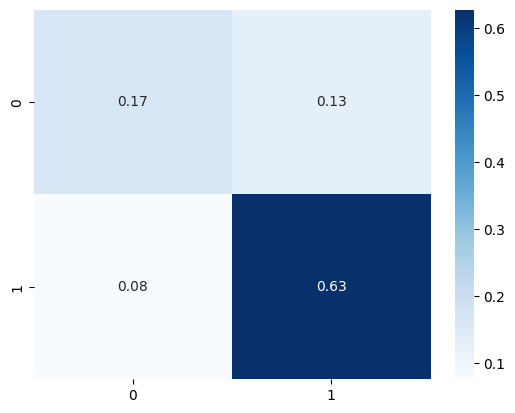

Accuracy score:  0.80
F1 score:        0.86
Precision score: 0.83
Recall score:    0.89


In [7]:
model = LogisticRegression(random_state=0)

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

sns.heatmap(
    metrics.confusion_matrix(y_test, y_predicted, normalize='all'),
    cmap='Blues', annot=True, fmt='.2f'
)
plt.show()

print('Accuracy score:  {:.2f}'.format( metrics.accuracy_score(y_test, y_predicted) ))
print('F1 score:        {:.2f}'.format( metrics.f1_score(y_test, y_predicted) ))
print('Precision score: {:.2f}'.format( metrics.precision_score(y_test, y_predicted) ))
print('Recall score:    {:.2f}'.format( metrics.recall_score(y_test, y_predicted) ))

In [107]:
models = {
    "Logistic regression":    LogisticRegression(random_state=0),
    "Support vector machine": SVC(probability=True, random_state=0),
    "LightGBM":               LGBMClassifier(random_state=0),
    "DecisionTree":           DecisionTreeClassifier(random_state=0),
    "RandomForest":           RandomForestClassifier(random_state=0),
    "GaussianNaiveBayes":     GaussianNB(),
}
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"Trained {name}")

Trained Logistic regression
Trained Support vector machine
Trained LightGBM
Trained DecisionTree
Trained RandomForest
Trained GaussianNaiveBayes


In [92]:
for name, model in models.items():
    print(
        f"{'{:.4f}'.format(f1_score(model.predict(X_test), y_test, average='macro'))} f1-macro for {name}"
    )

print()

for name, model in models.items():
    print(
        f"{'{:.4f}'.format(roc_auc_score(model.predict(X_test), y_test, average='macro'))} roc_auc_score macro for {name}"
    )

0.7412 f1-macro for Logistic regression
0.6820 f1-macro for Support vector machine
0.6915 f1-macro for LightGBM
0.6065 f1-macro for DecisionTree
0.7217 f1-macro for RandomForest
0.7245 f1-macro for GaussianNaiveBayes

0.7596 roc_auc_score macro for Logistic regression
0.7316 roc_auc_score macro for Support vector machine
0.6959 roc_auc_score macro for LightGBM
0.6042 roc_auc_score macro for DecisionTree
0.7217 roc_auc_score macro for RandomForest
0.7189 roc_auc_score macro for GaussianNaiveBayes


In [113]:
curves = []
for name, model in models.items():
    prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, prob)
    
    curves.append({
        'name': name,
        'auc': '{:.2f}'.format(
            round(
                roc_auc_score(model.predict(X_test), y_test, average="macro")
            , 2)
        ),
        'fpr': fpr,
        'tpr': tpr,
    })

In [115]:
r_probs = [0 for _ in y_test]
r_auc = roc_auc_score(y_test, r_probs)
fpr, tpr, _ = roc_curve(y_test, r_probs)

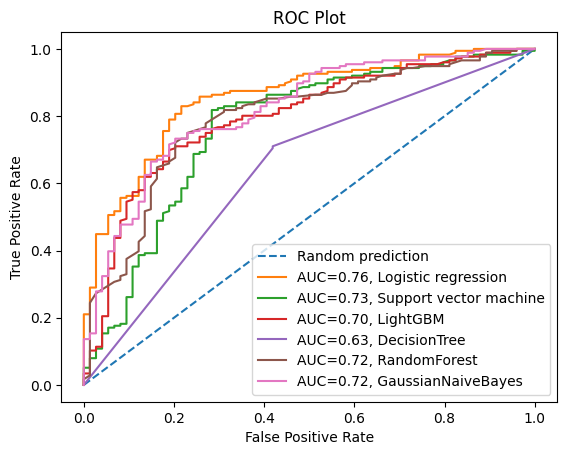

In [116]:
plt.plot(fpr, tpr, linestyle='--', label='Random prediction')
plt.plot(curves[0]['fpr'], curves[0]['tpr'], label=f"AUC={curves[0]['auc']}, {curves[0]['name']}")
plt.plot(curves[1]['fpr'], curves[1]['tpr'], label=f"AUC={curves[1]['auc']}, {curves[1]['name']}")
plt.plot(curves[2]['fpr'], curves[2]['tpr'], label=f"AUC={curves[2]['auc']}, {curves[2]['name']}")
plt.plot(curves[3]['fpr'], curves[3]['tpr'], label=f"AUC={curves[3]['auc']}, {curves[3]['name']}")
plt.plot(curves[4]['fpr'], curves[4]['tpr'], label=f"AUC={curves[4]['auc']}, {curves[4]['name']}")
plt.plot(curves[5]['fpr'], curves[5]['tpr'], label=f"AUC={curves[5]['auc']}, {curves[5]['name']}")

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()